In [34]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
%matplotlib inline
from mpl_toolkits.mplot3d.axes3d import *
import os

# resource: https://astrogeology.usgs.gov/search/map/Moon/LMMP/Apollo15/LRO_NAC_DEM_Apollo_15_26N004E_150cmp
# Height (Elevation m) = DN; Planetary Radius = DN + 1737400m
Image.MAX_IMAGE_PIXELS = None
dem_path = '../dataset/LRO_NAC_DEM_Apollo_15_26N004E_150cmp.tif'


img = Image.open(dem_path)
img = np.asarray(img, dtype=np.float16)
width,height = img.shape[0],img.shape[1]
mid_x,mid_y = int(width/2)-1500,int(height/2)-1500
crop_height, crop_width = 1000,1000
img = img[mid_x:mid_x+crop_width,mid_y:mid_y+crop_height]
img = img - np.mean(img)

out_path='../dataset/Map_3'

In [35]:
def save_dem(img, out_path='../dataset', name='dem.npy'):
    out_name = os.path.join(out_path, name)
    with open(out_name, 'wb') as f:
        np.save(f, img)
    return out_name

def open_dem(dem_path):
    with open(dem_path, 'rb') as f:
        dem = np.load(f)
    return dem

In [36]:
#from matplotlib.mlab import griddata

def plot_mesh(img, export_img=False, out_path='../dataset'):
    xi = np.arange(0, img.shape[0],1) * 0.5 # Grid in meters
    yi = np.arange(0, img.shape[1],1) * 0.5 # Grid in meters
    z = img.flatten() # Height in meters
    Z = img
    X, Y = np.meshgrid(xi, yi)

    fig = plt.figure(figsize=(20,16))
    ax = Axes3D(fig)
  #  ax.scatter3D(X,Y,z,c=z,cmap=plt.cm.jet)  

    my_cmap = plt.cm.RdYlGn_r
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=my_cmap,
                       linewidth=0, antialiased=True)
    fig.colorbar(surf, ax = ax,
             shrink = 0.3,
             aspect = 10,
             format="%.1f m")
    
    cset = ax.contourf(X, Y, Z,
                   zdir ='z',
                   offset = -20,
                   cmap = 'Greys_r')
    fig.suptitle('LRO NAC DEM Apollo 15 26N004E  \n ---------------------------------------------------------------\n Obszar: X [{}:{}]  | Y [{}:{}]  '.format(
        mid_x,mid_x+crop_width,mid_y,mid_y+crop_height), fontsize=20)

    ax.set_xlabel('Siatka mapy: kierunek X [m]', fontsize = 16)
    ax.set_ylabel('Siatka mapy: kierunek Y [m]', fontsize = 16)
    ax.set_zlabel('Wysokość terenu [m]', fontsize = 16)

    ax.set_zlim(-20, 20)
    if export_img:
        plot_name = os.path.join(out_path, 'DEM_plot.jpg')
        plt.savefig(plot_name)
    plt.show()
    



In [37]:
from math import sqrt, atan
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from matplotlib import colors

# 3D slope calculation
# https://www.youtube.com/watch?v=5gVdvxjKh4A
def calculate_slope(img, deg=True):
    slope = np.zeros_like(img)
    res = 0.5     # x,y res = 0,5 m
    for x in range(2,img.shape[0]-2):
        for y in range(2,img.shape[1]-2):
          #  mean_xp_axis = img[x+1:x+2,y].mean() 
          #  mean_xn_axis = img[x-2:x-1,y].mean()
          #  dz_dx = mean_xp_axis - mean_xn_axis/(res*2)
            
          #  mean_yp_axis = img[x,y+1:y+2].mean() 
          #  mean_yn_axis = img[x,y-2:y-1].mean()
          #  dz_dy = mean_yp_axis - mean_yn_axis/(res*2)
            dz_dx = (img[x+1,y]-img[x-1,y]) /(res*2)
            dz_dy = ((img[x,y+1]-img[x,y-1])/(res*2))
            slope[x,y]= atan(sqrt(dz_dx**2+dz_dy**2))
    if deg:
        slope = np.rad2deg(slope)
        print('Min slope: {} Median slope: {} Max slope: {}'.format(np.min(slope), np.median(slope[slope>0]), np.max(slope)))
    slope = slope[2:img.shape[0]-2,2:img.shape[1]-2]
    return slope

def safe_area(safe_slope, thresh=40):
    safe_slope[safe_slope < thresh] = 0
    safe_slope[safe_slope >= thresh] = 255
    return np.array(safe_slope,dtype=np.int8)

def plot_safe_slope(safe_slope, export_img=False, out_path='../dataset'):
    danger_color = (0.6, 0.3, 0.3, 0.6)
    safe_color = (0.1, 0.7, 0.2, 0.1)
    cmp=ListedColormap([danger_color,safe_color])
    with plt.style.context('ggplot'):
        fig, ax = plt.subplots(figsize=(10,10), dpi=144)
        xi = np.arange(0, img.shape[0],1) * 0.5 # Grid in meters
        yi = np.arange(0, img.shape[1],1) * 0.5 # Grid in meters
        #Z = 
        #plt.pcolormesh(safe_slope, cmap='Greys')
        #plt.scatter(xi,yi, cmap='Greys')

        ax.imshow(safe_slope, cmap=cmp)
        fig.suptitle("Ocena możliwości trawersu", fontsize=16)
        plt.xlabel("Kierunek x [m]", fontsize=10)
        plt.ylabel("Kierunek Y [m]", fontsize=10)
        ax.invert_yaxis()

        locs_x = (np.arange(0, safe_slope.shape[0], step=60)) 
        labels_x = locs_x/2
        plt.xticks(ticks=locs_x, labels=labels_x)

        locs_y = (np.arange(0, safe_slope.shape[1], step=60)) 
        labels_y = locs_y/2
        plt.yticks(ticks=locs_y, labels=labels_y)
        

        legend_handles = [Patch(color=safe_color, label='Bezpieczny'),  
                          Patch(color=danger_color, label='Niebezpieczny')]  
        plt.legend(handles=legend_handles, ncol=2, bbox_to_anchor=[0.5, 1.02], loc='lower center', fontsize=8, handlelength=.8)
        #plt.legend()
        if export_img:
            plot_name = os.path.join(out_path, 'Safe_slope_plot.jpg')
            plt.savefig(plot_name)
        plt.show()
        
def analyze_slope_map(img, export_img=False, out_path='../dataset'):
    slope = calculate_slope(img)
    safe_slope = safe_area(slope)
    plot_safe_slope(safe_slope,export_img, out_path)

In [38]:
## PLOT MAP START AND FINISH

def plot_start_end(img,start,end, export_img=False, out_path='../dataset'):

    danger_color = (0.3, 0.3, 0.3, 0.3)
    safe_color = (0.9, 1, 0.9, 0.1)

    markers_color = (0.92, 0.7, 0, 0.8)
    
    font = {'family': "monospace",
        'color':  (0.92, 0.7, 0, 1),
        'weight': 'bold',
        'size': 10,
        }

    
    cmp=ListedColormap([danger_color,safe_color])
    with plt.style.context('ggplot'):
        fig, ax = plt.subplots(figsize=(10,10), dpi=144)
        xi = np.arange(0, img.shape[0],1) * 0.5 # Grid in meters
        yi = np.arange(0, img.shape[1],1) * 0.5 # Grid in meters
        #Z = 
        #plt.pcolormesh(safe_slope, cmap='Greys')
        #plt.scatter(xi,yi, cmap='Greys')

        ax.imshow(img, cmap=cmp)
        start_point = ax.plot(start[0], start[1], marker="H", markeredgecolor=markers_color,
                            markersize=12, markerfacecolor=markers_color, label='Punkt startowy') # Start point plot 
        ax.text(start[0]+start[0]*0.02, 
                start[1]+start[1]*0.02, r'Punkt startowy', fontdict=font) 
        end_point = ax.plot(end[0], end[1], marker="X", label='Punkt końcowy', 
                            markersize=12, markeredgecolor=markers_color,markerfacecolor=markers_color) # End point plot )
        ax.text(end[0]+end[0]*0.02, 
                end[1]+end[1]*0.02, r'Punkt końcowy', fontdict=font) 
        
        plt.title("Punkt startu i mety dla trasy", fontsize=14)
        plt.xlabel("Kierunek x [m]", fontsize=10)
        plt.ylabel("Kierunek Y [m]", fontsize=10)
        ax.invert_yaxis()

        locs_x = (np.arange(0, img.shape[0], step=60)) 
        labels_x = locs_x/2
        plt.xticks(ticks=locs_x, labels=labels_x)

        locs_y = (np.arange(0, img.shape[1], step=60)) 
        labels_y = locs_y/2
        plt.yticks(ticks=locs_y, labels=labels_y)
        

#         legend_handles = [Patch(color=markers_color, label='Punkty na trasie'),]   
#         plt.legend(handles=legend_handles, ncol=2, 
#                    bbox_to_anchor=[0.5, 1.02], loc='lower center', fontsize=8, handlelength=.8)
        #plt.legend()
        if export_img:
            plot_name = os.path.join(out_path, 'Start_end_plot.jpg')
            plt.savefig(plot_name)
        plt.show()


In [39]:
dem_name = save_dem(img, out_path=out_path)
img = open_dem(dem_name)

C:\Users\kafra\AppData\Local\Temp/ipykernel_776/2058102885.py:11: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


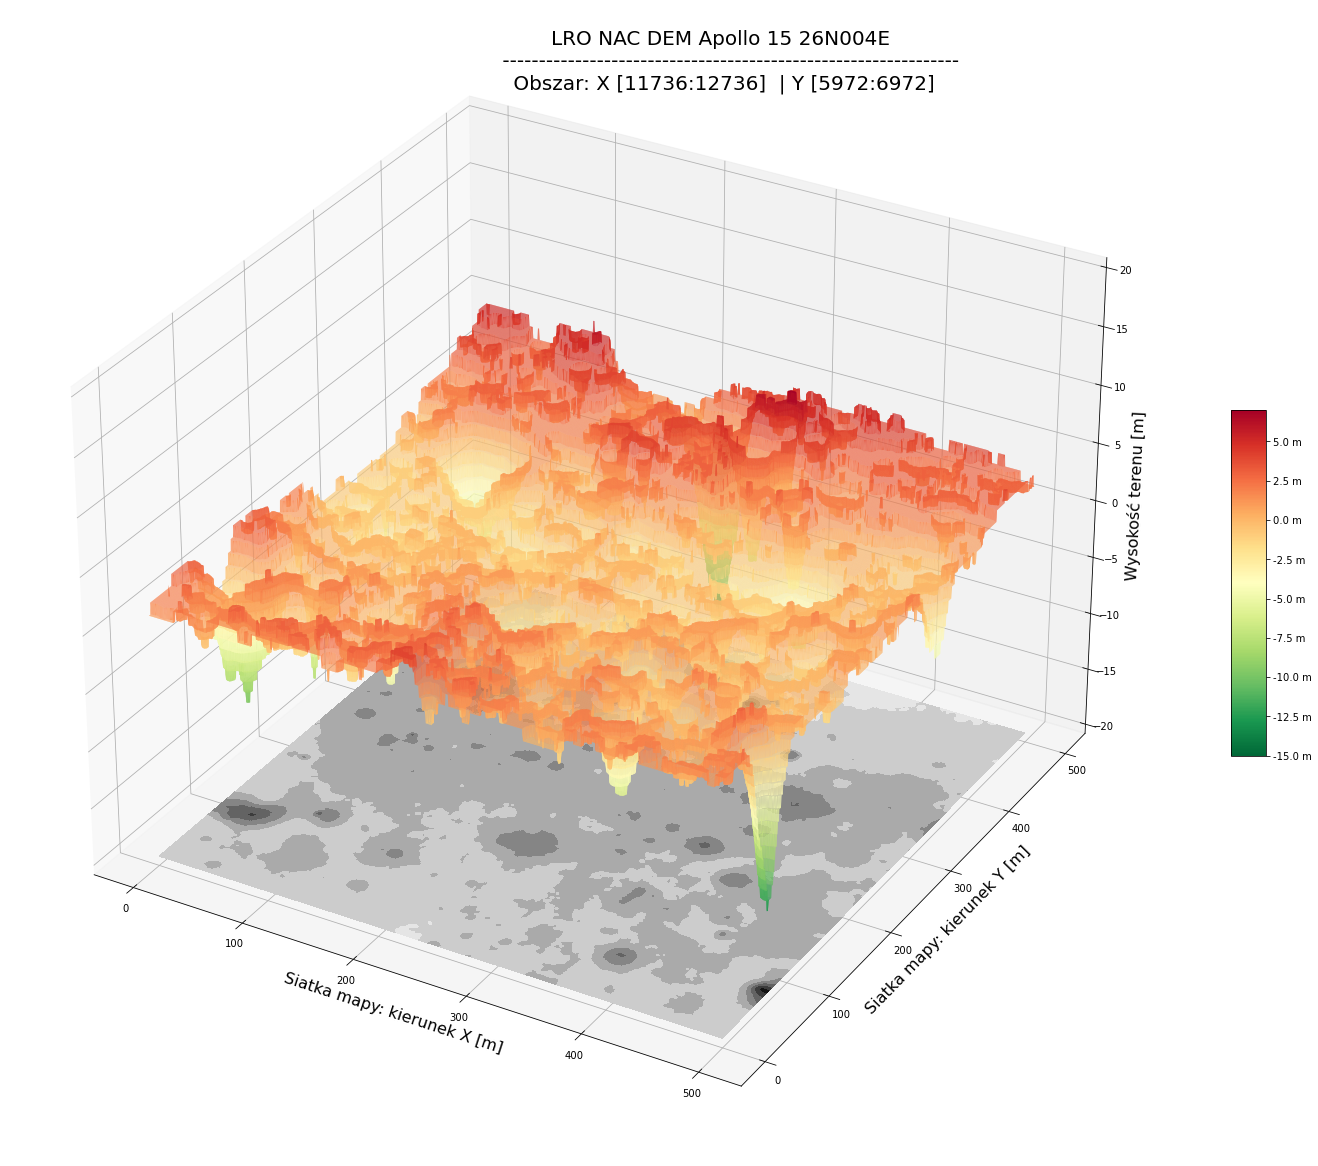

In [40]:
#plot_mesh(img, False)
plot_mesh(img, True, out_path=out_path)

Min slope: 0.0 Median slope: 45.0 Max slope: 72.4375


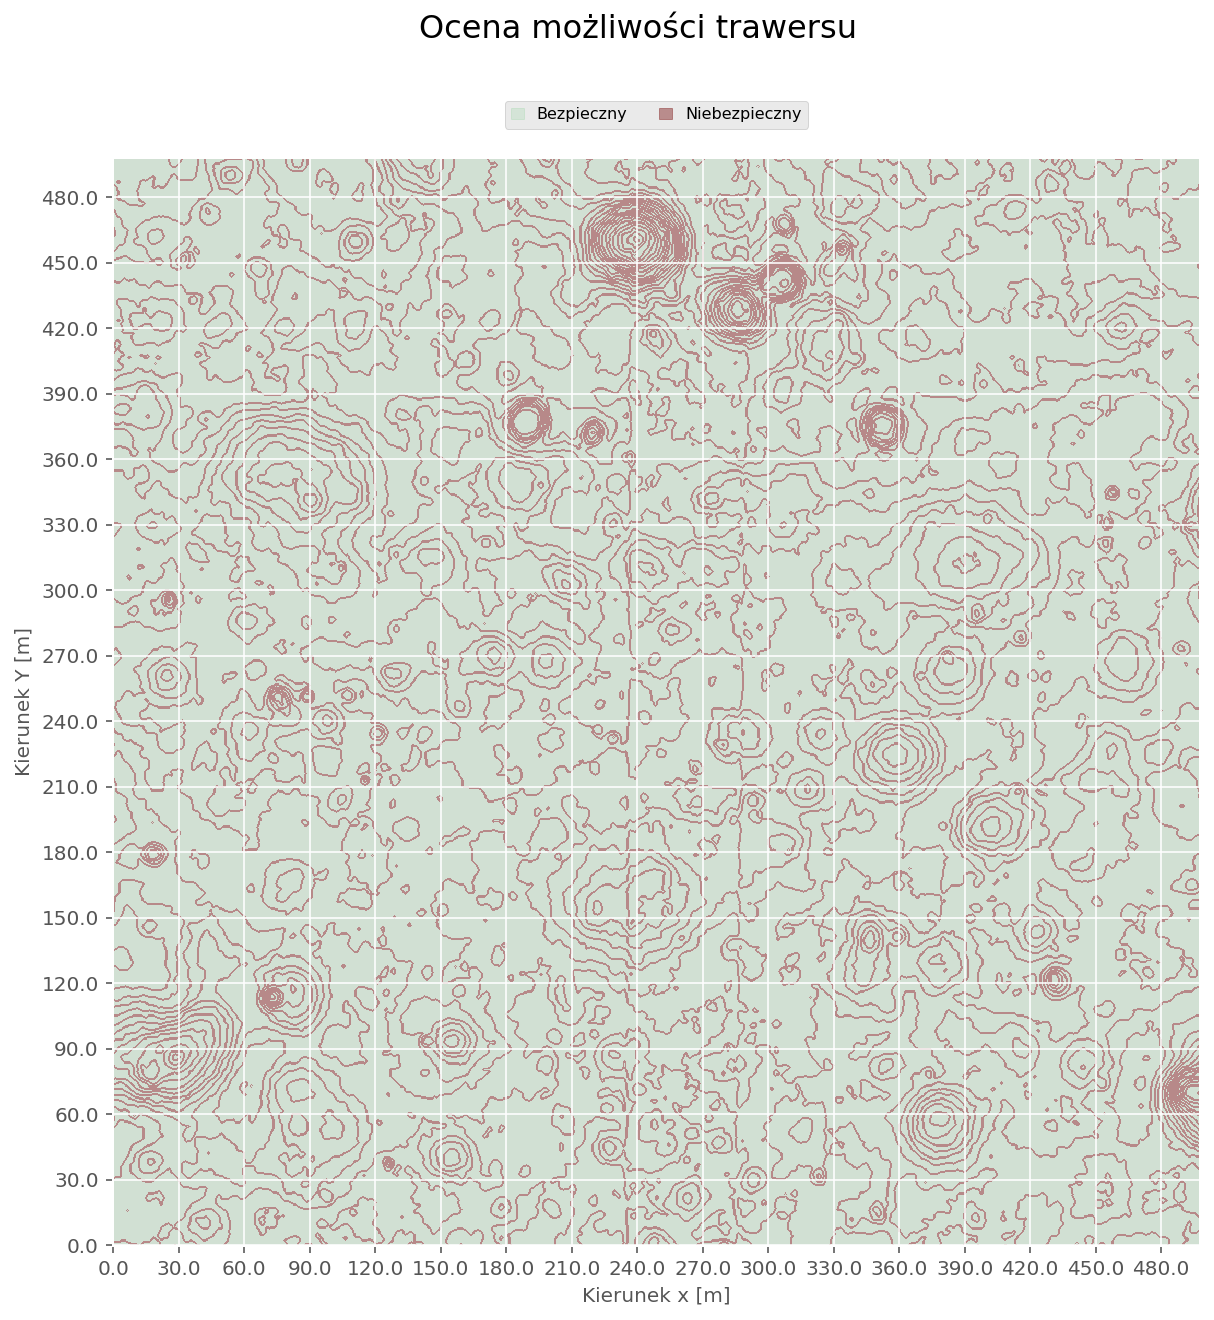

Min slope: 0.0 Median slope: 45.0 Max slope: 72.4375


'../dataset/Map_3\\occupancy_grid.npy'

In [41]:
analyze_slope_map(img, True, out_path=out_path)
img_plot = calculate_slope(img)
save_dem(img_plot, out_path, 'slope.npy')
img_plot = safe_area(img_plot)
save_dem(img_plot, out_path, 'occupancy_grid.npy')

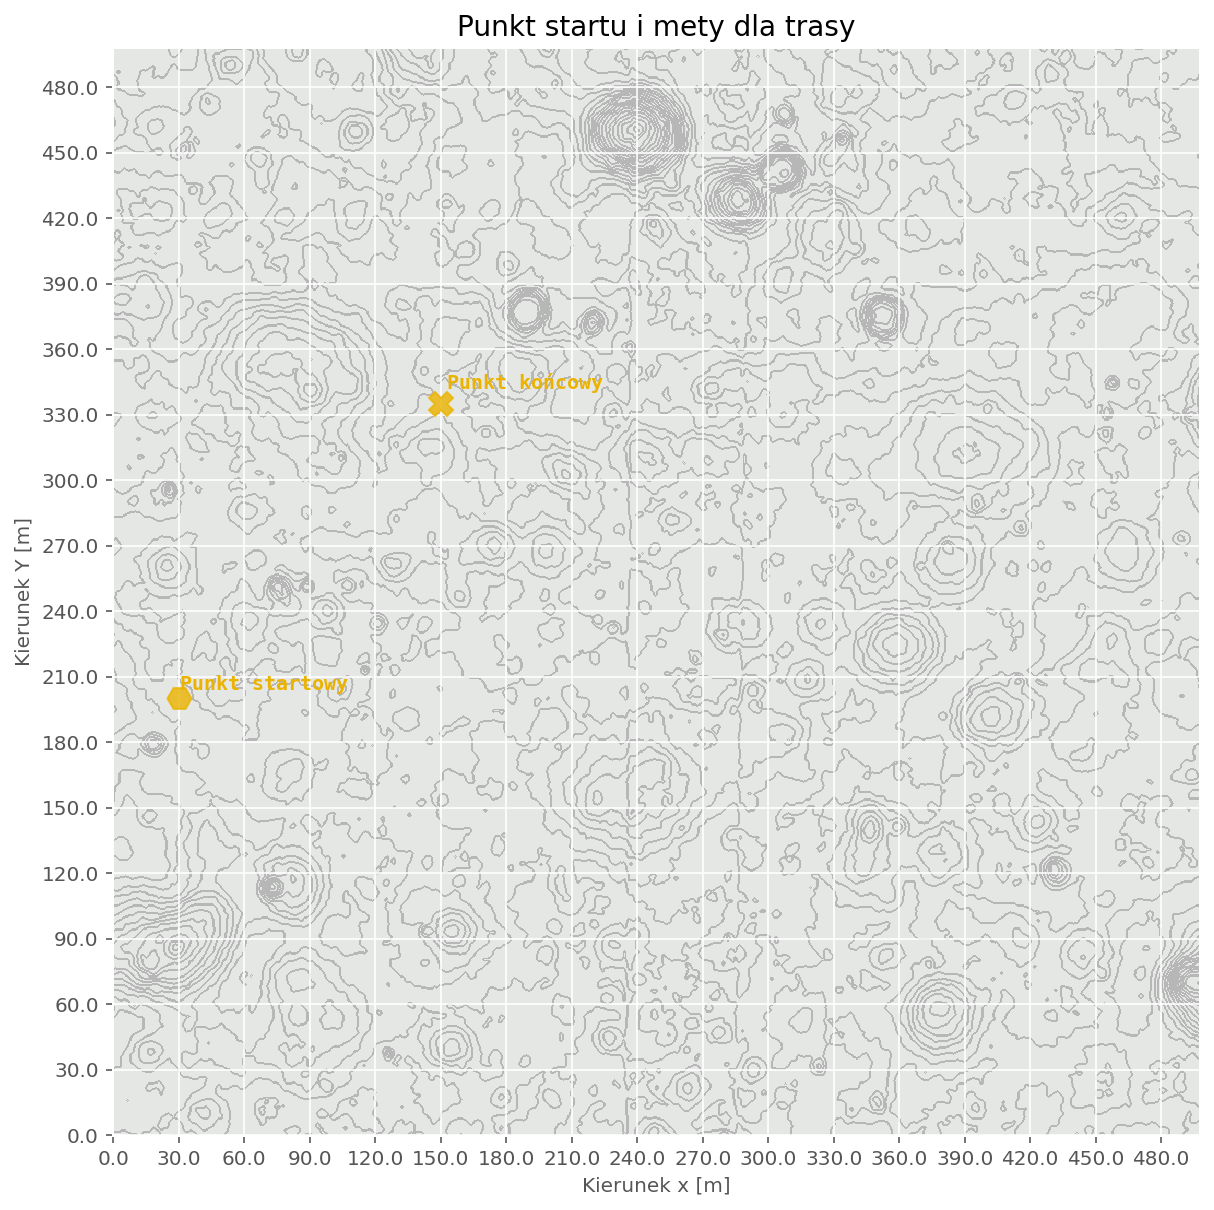

In [42]:
plot_start_end(img_plot,(60,400),(300,670),True,  out_path=out_path)

In [43]:
# Implemennt efficency analysis funcs

In [44]:
# Implement plotting gathered data 